# Imports

In [1]:
!pip install transformers

In [2]:
import os
import re
import json
import nltk
import torch
import numpy as np
import pandas as pd
import seaborn as sns
import torch.nn.functional as F

from matplotlib import pyplot as plt
from torch import nn
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.utils import shuffle
from transformers import AutoModel, AutoTokenizer
from tqdm import trange, tqdm
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from nltk.probability import FreqDist
from sklearn.feature_extraction.text import CountVectorizer
from collections import Counter

import warnings
warnings.filterwarnings('ignore')

In [3]:
nltk.download('omw-1.4', quiet=True)
sns.set_style('darkgrid')

In [4]:
os.chdir('/kaggle/input/kontur')
os.getcwd()
TRAIN_DATA_PATH = 'dataset/train.json'
TEST_DATA_PATH = 'dataset/test.json'

BIDAF_10EPOCHS_LOAD_FROM_PATH = '/kaggle/input/bidaf-dump10epochs/BiDAF_dump10epochs.pt'
BIDAF_CLS_LOAD_FROM_PATH = '/kaggle/input/bidaf-cls/BiDAF_cls.pt'
BIDAF_MAIN_MODEL_LOAD_FROM_PATH = '/kaggle/input/bidaf-main-model/BiDAF_main_model.pt'

BIDAF_10EPOCHS_SAVE_TO_PATH = '/kaggle/working/BiDAF_dump10epochs.pt'
BIDAF_CLS_SAVE_TO_PATH = '/kaggle/working/BiDAF_cls.pt'
BIDAF_MAIN_MODEL_SAVE_TO_PATH = '/kaggle/working/BiDAF_main_model.pt'

BATCH_SIZE = 4
EMB_DIM = 768
SEQ_LEN = 512
HIDDEN_SIZE = EMB_DIM // 2

TOKENIZER_CHECKPOINT = 'DeepPavlov/rubert-base-cased'
CONTRACT_SECURITY_LABEL = 'обеспечение исполнения контракта'
WARRANTY_COVERAGE_LABEL = 'обеспечение гарантийных обязательств'

TRAIN_MODE = True

SEED = 0
torch.manual_seed(SEED)

# EDA

In [5]:
with open(TRAIN_DATA_PATH, 'r') as train_file:
    train = json.load(train_file)
with open(TEST_DATA_PATH, 'r') as train_file:
    test = json.load(train_file)

In [6]:
print(f'train: {len(train)}')
print(f'test: {len(test)}')

train: 1799
test: 318


In [7]:
train[0].keys()

dict_keys(['id', 'text', 'label', 'extracted_part'])

In [8]:
train[0] # Example

{'id': 809436509,
 'text': 'Извещение о проведении открытого конкурса в электронной форме для закупки №0328300032822000806 Общая информация Номер извещения 0328300032822000806 Наименование объекта закупки Поставка продуктов питания Способ определения поставщика (подрядчика, исполнителя) Открытый конкурс в бль Порядок внесения денежных средств в качестве обеспечения заявки на участие в закупке, а также условия гарантии Обеспечение заявки на участие в закупке может предоставляться участником закупки в виде денежных средств или независимой гарантии, предусмотренной ст. 45 Федерального закона № 44-ФЗ. Выбор способа обеспечения осуществляется участником закупки самостоятельно. Срок действия независимой гарантии должен составлять не менее месяца с даты окончания срока подачи заявок. Обеспечение заявки на участие в закупке предоставляется в соответствии с ч. 5 ст. 44 Федерального закона № 44-ФЗ. Условия независимой гарантии в соответствии со ст. 45 Федерального закона № 44-ФЗ. Реквизиты счета

In [9]:
test[0].keys()

dict_keys(['id', 'text', 'label'])

In [10]:
test[0]

{'id': 762883279,
 'text': 'МУНИЦИПАЛЬНЫЙ КОНТРАКТ № ______ на оказание услуг по техническому обслуживанию и ремонту принтеров и многофункциональных устройств, заправке и восстановлению картриджей (идентификационный код закупки 223861800296886010100100590019511244) г. Ханты-Мансийск «___» ____________ 2022 г.  (или) возмещения убытков причинённых Исполнителем убытков. 6. Обеспечение исполнения контракта 6.1. Исполнение контракта обеспечиваются предоставлением независимой гарантии, выданной банком и соответствующей требованиям Федерального закона от 05.04.2013 № 44-ФЗ «О контрактной системе в сфере закупок товаров, работ, услуг для обеспечения государственных и муниципальных нужд», или внесением денежных средств на указанный заказчиком счет, на котором в соответствии с законодательством Российской Федерации учитываются операции со средствами, поступающими заказчику. Способ обеспечения исполнения контракта, срок действия независимой гарантии определяются в соответствии с требованиями Фед

In [11]:
train_df = pd.json_normalize(train)
test_df = pd.json_normalize(test)

In [12]:
train_df.head()

,id,text,label,extracted_part.text,extracted_part.answer_start,extracted_part.answer_end
0,809436509,Извещение о проведении открытого конкурса в эл...,обеспечение исполнения контракта,[Размер обеспечения исполнения контракта 6593....,[1279],[1343]
1,854885310,ТРЕБОВАНИЯ К СОДЕРЖАНИЮ ЗАЯВКИ участника запро...,обеспечение исполнения контракта,[Поставщик должен предоставить обеспечение исп...,[1222],[1318]
2,4382157,Извещение о проведении электронного аукциона д...,обеспечение исполнения контракта,[Размер обеспечения исполнения контракта 10.00%],[1297],[1343]
3,184555082,Извещение о проведении электронного аукциона д...,обеспечение исполнения контракта,[Размер обеспечения исполнения контракта 10.00%],[1304],[1350]
4,211645258,Извещение о проведении электронного аукциона д...,обеспечение исполнения контракта,[Размер обеспечения исполнения контракта 10.00%],[1302],[1348]


In [13]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1799 entries, 0 to 1798
Data columns (total 6 columns):
 #   Column                       Non-Null Count  Dtype 
---  ------                       --------------  ----- 
 0   id                           1799 non-null   int64 
 1   text                         1799 non-null   object
 2   label                        1799 non-null   object
 3   extracted_part.text          1799 non-null   object
 4   extracted_part.answer_start  1799 non-null   object
 5   extracted_part.answer_end    1799 non-null   object
dtypes: int64(1), object(5)
memory usage: 84.5+ KB


In [14]:
print('Train labels:', train_df.label.unique())
print('Test labels:',  test_df.label.unique())

Train labels: ['обеспечение исполнения контракта' 'обеспечение гарантийных обязательств']
Test labels: ['обеспечение исполнения контракта' 'обеспечение гарантийных обязательств']


## Train labeles class balance

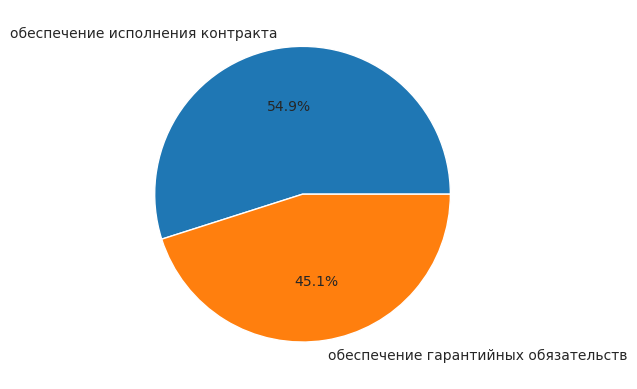

In [15]:
plt.pie(train_df.label.value_counts(), labels=train_df.label.unique().tolist(), autopct='%1.1f%%')
plt.show()

## Test labels class balance

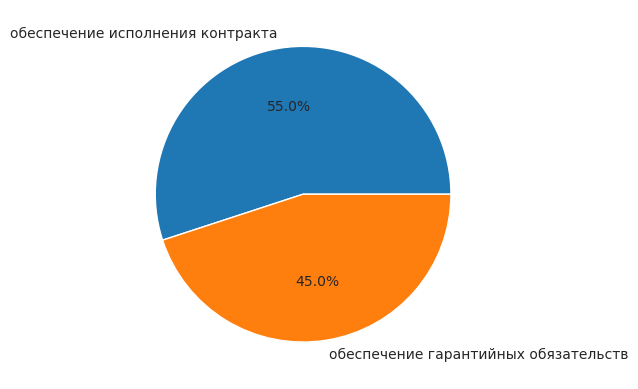

In [16]:
plt.pie(test_df.label.value_counts(), labels=test_df.label.unique().tolist(), autopct='%1.1f%%')
plt.show()

In [17]:
train_df['length'] = train_df['text'].str.len()
train_df.head()

,id,text,label,extracted_part.text,extracted_part.answer_start,extracted_part.answer_end,length
0,809436509,Извещение о проведении открытого конкурса в эл...,обеспечение исполнения контракта,[Размер обеспечения исполнения контракта 6593....,[1279],[1343],2594
1,854885310,ТРЕБОВАНИЯ К СОДЕРЖАНИЮ ЗАЯВКИ участника запро...,обеспечение исполнения контракта,[Поставщик должен предоставить обеспечение исп...,[1222],[1318],2420
2,4382157,Извещение о проведении электронного аукциона д...,обеспечение исполнения контракта,[Размер обеспечения исполнения контракта 10.00%],[1297],[1343],2492
3,184555082,Извещение о проведении электронного аукциона д...,обеспечение исполнения контракта,[Размер обеспечения исполнения контракта 10.00%],[1304],[1350],2644
4,211645258,Извещение о проведении электронного аукциона д...,обеспечение исполнения контракта,[Размер обеспечения исполнения контракта 10.00%],[1302],[1348],2652


In [18]:
train_df['word_count'] = train_df.text.apply(lambda x: len(x.split()))
train_df.head()

,id,text,label,extracted_part.text,extracted_part.answer_start,extracted_part.answer_end,length,word_count
0,809436509,Извещение о проведении открытого конкурса в эл...,обеспечение исполнения контракта,[Размер обеспечения исполнения контракта 6593....,[1279],[1343],2594,317
1,854885310,ТРЕБОВАНИЯ К СОДЕРЖАНИЮ ЗАЯВКИ участника запро...,обеспечение исполнения контракта,[Поставщик должен предоставить обеспечение исп...,[1222],[1318],2420,296
2,4382157,Извещение о проведении электронного аукциона д...,обеспечение исполнения контракта,[Размер обеспечения исполнения контракта 10.00%],[1297],[1343],2492,306
3,184555082,Извещение о проведении электронного аукциона д...,обеспечение исполнения контракта,[Размер обеспечения исполнения контракта 10.00%],[1304],[1350],2644,298
4,211645258,Извещение о проведении электронного аукциона д...,обеспечение исполнения контракта,[Размер обеспечения исполнения контракта 10.00%],[1302],[1348],2652,303


In [19]:
train_df['mean_word_length'] = train_df.text.map(lambda sample: np.mean([len(word) for word in sample.split()]))
train_df.head()

,id,text,label,extracted_part.text,extracted_part.answer_start,extracted_part.answer_end,length,word_count,mean_word_length
0,809436509,Извещение о проведении открытого конкурса в эл...,обеспечение исполнения контракта,[Размер обеспечения исполнения контракта 6593....,[1279],[1343],2594,317,7.186120
1,854885310,ТРЕБОВАНИЯ К СОДЕРЖАНИЮ ЗАЯВКИ участника запро...,обеспечение исполнения контракта,[Поставщик должен предоставить обеспечение исп...,[1222],[1318],2420,296,7.175676
2,4382157,Извещение о проведении электронного аукциона д...,обеспечение исполнения контракта,[Размер обеспечения исполнения контракта 10.00%],[1297],[1343],2492,306,7.147059
3,184555082,Извещение о проведении электронного аукциона д...,обеспечение исполнения контракта,[Размер обеспечения исполнения контракта 10.00%],[1304],[1350],2644,298,7.872483
4,211645258,Извещение о проведении электронного аукциона д...,обеспечение исполнения контракта,[Размер обеспечения исполнения контракта 10.00%],[1302],[1348],2652,303,7.752475


In [20]:
np.mean([len(sent) for sent in tokenize.sent_tokenize(train_df.text[0])])

143.16666666666666

In [21]:
train_df['mean_sent_length'] = train_df['text'].map(
    lambda sample: np.mean([len(sent) for sent in tokenize.sent_tokenize(sample)]))
train_df.head()

,id,text,label,extracted_part.text,extracted_part.answer_start,extracted_part.answer_end,length,word_count,mean_word_length,mean_sent_length
0,809436509,Извещение о проведении открытого конкурса в эл...,обеспечение исполнения контракта,[Размер обеспечения исполнения контракта 6593....,[1279],[1343],2594,317,7.186120,143.166667
1,854885310,ТРЕБОВАНИЯ К СОДЕРЖАНИЮ ЗАЯВКИ участника запро...,обеспечение исполнения контракта,[Поставщик должен предоставить обеспечение исп...,[1222],[1318],2420,296,7.175676,344.857143
2,4382157,Извещение о проведении электронного аукциона д...,обеспечение исполнения контракта,[Размер обеспечения исполнения контракта 10.00%],[1297],[1343],2492,306,7.147059,248.300000
3,184555082,Извещение о проведении электронного аукциона д...,обеспечение исполнения контракта,[Размер обеспечения исполнения контракта 10.00%],[1304],[1350],2644,298,7.872483,263.500000
4,211645258,Извещение о проведении электронного аукциона д...,обеспечение исполнения контракта,[Размер обеспечения исполнения контракта 10.00%],[1302],[1348],2652,303,7.752475,330.625000


In [22]:
def visualize(col, label):
    
    print()
    fig, axs = plt.subplots(1,2, figsize=(16,8))
    sns.boxplot(y=col, hue=label, data=train_df, ax=axs[0])
    plt.ylabel(col, labelpad=12.5)
    
    sns.kdeplot(x=col, hue=label, data=train_df, ax=axs[1])
    plt.legend(train_df[label].unique())
    plt.xlabel('')
    plt.ylabel('')
    
    plt.show()

## Исполнение контракта vs гарантийные обязательства

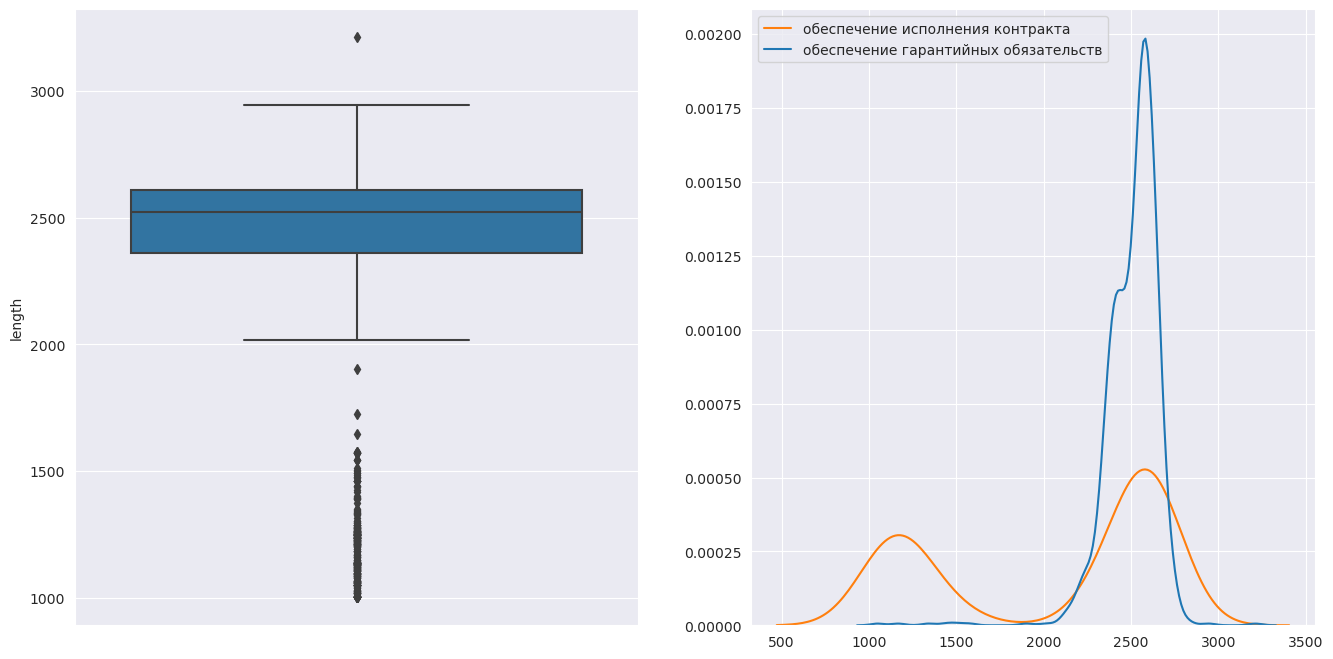

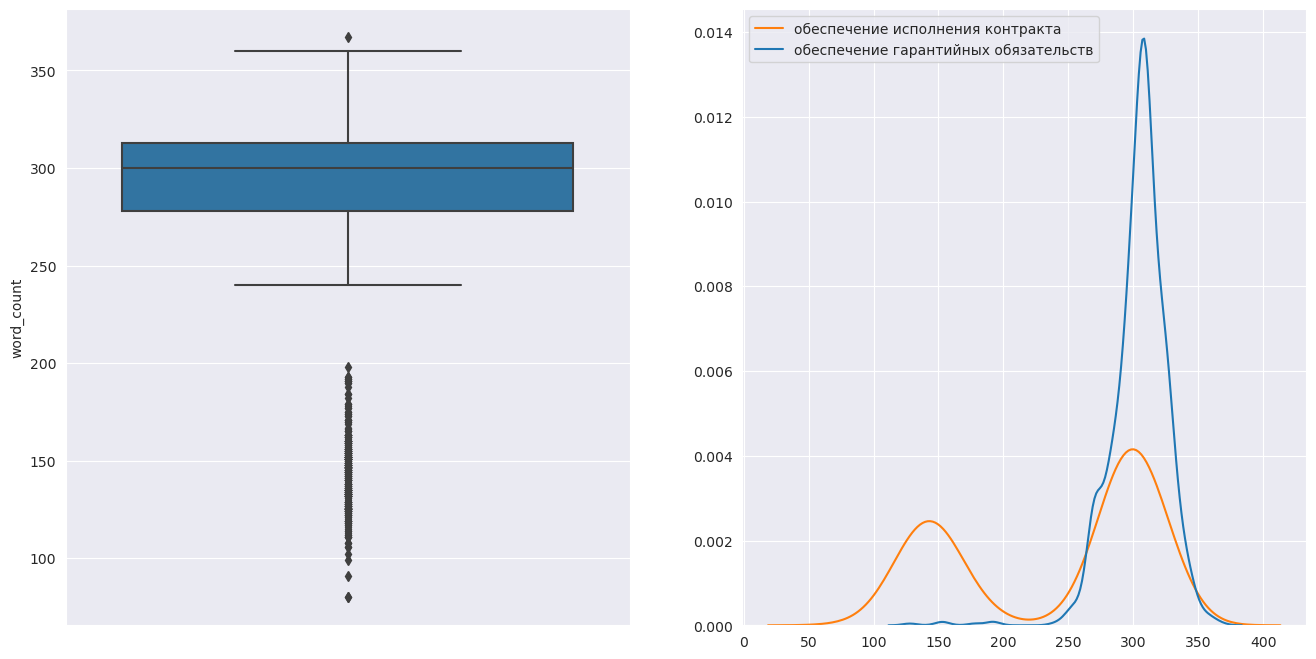

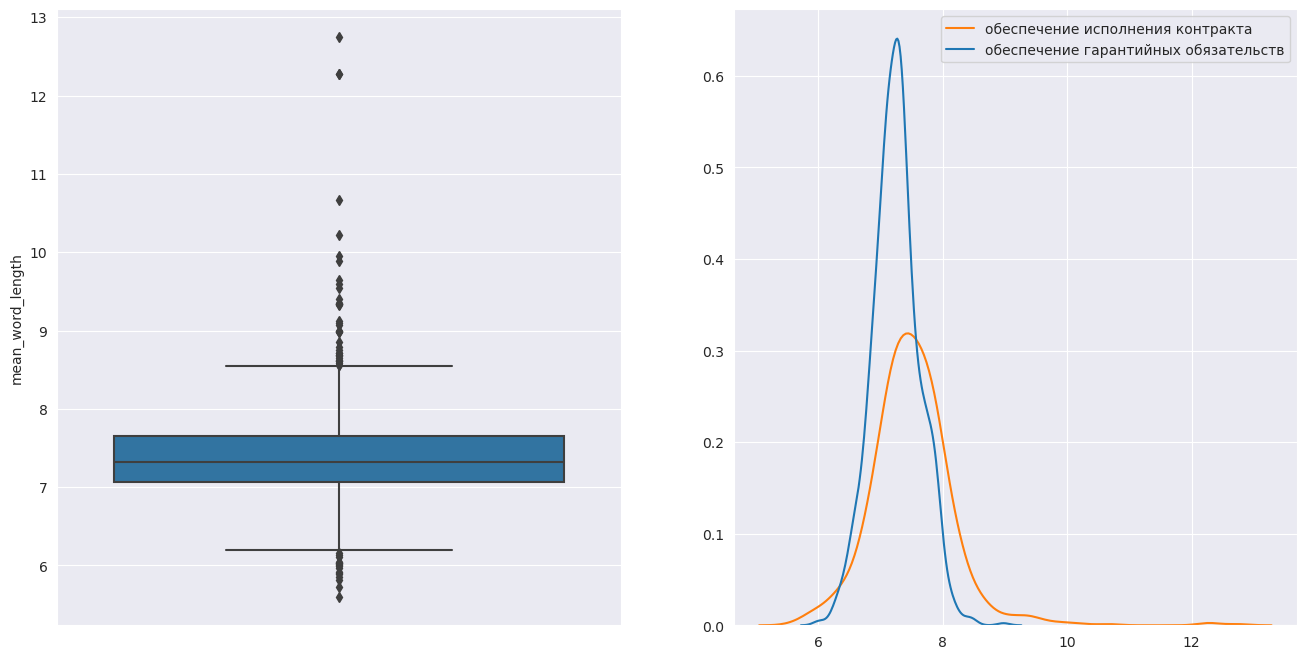

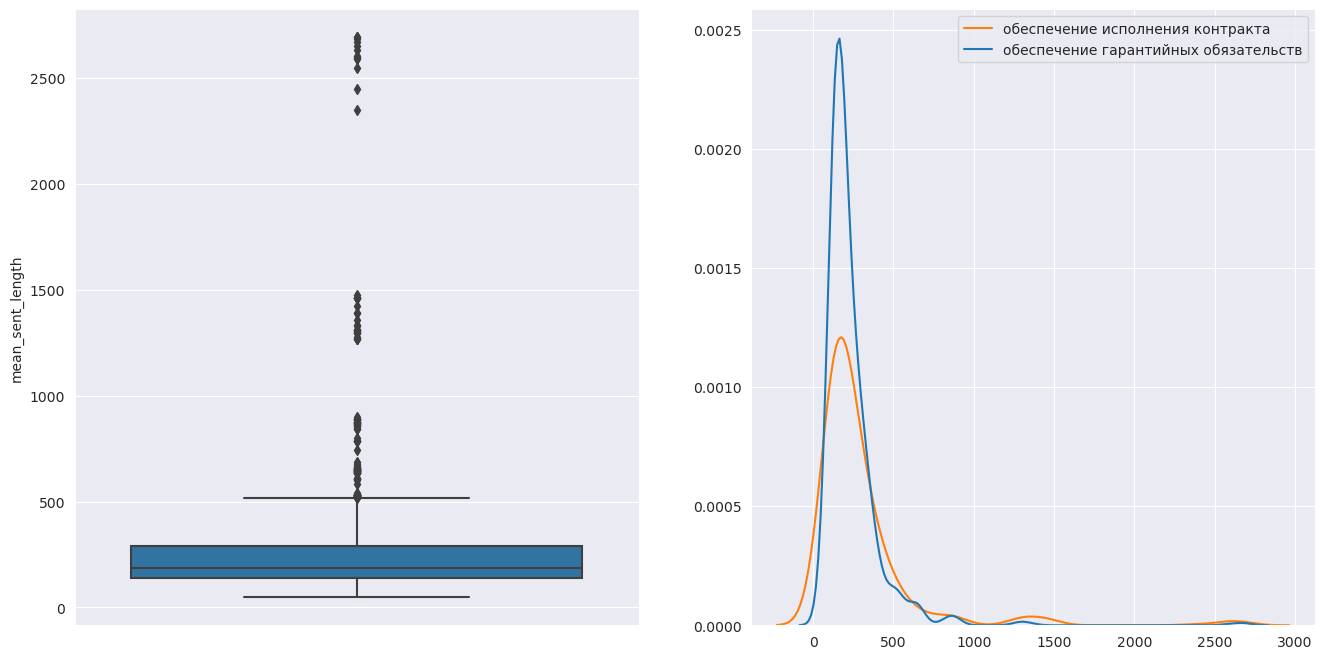

In [23]:
features = train_df.columns.tolist()[6:]
for feature in features:
    visualize(feature, 'label')

## Extracted vs blank

In [24]:
train_df['extracted'] = train_df['extracted_part.text'].apply(lambda x: x[0] != '')

In [25]:
1 - (train_df['extracted'].sum() / train_df.shape[0]) # missing

0.17065036131183986

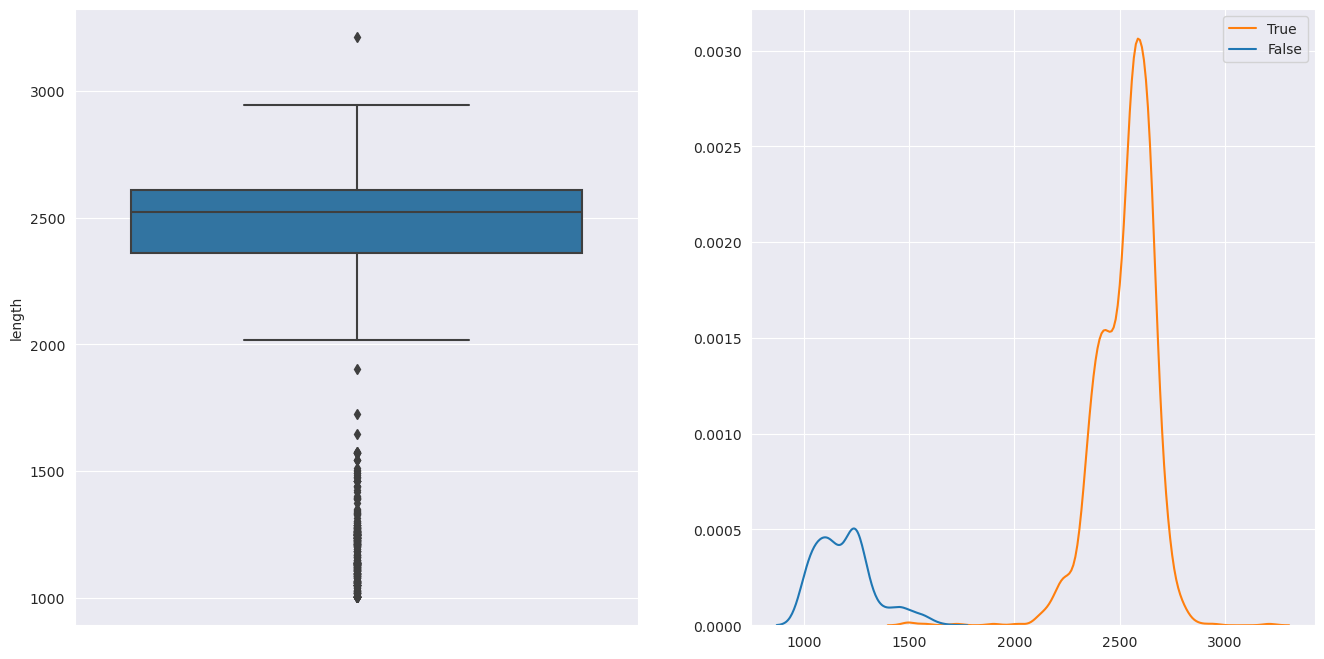

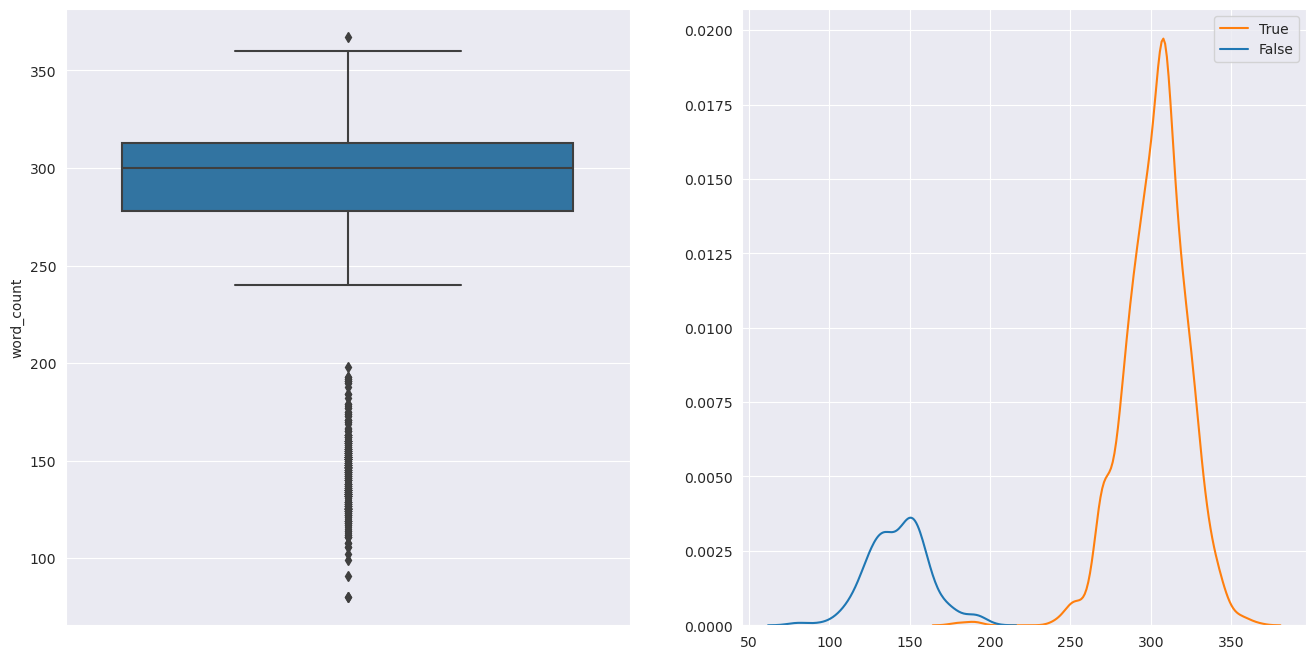

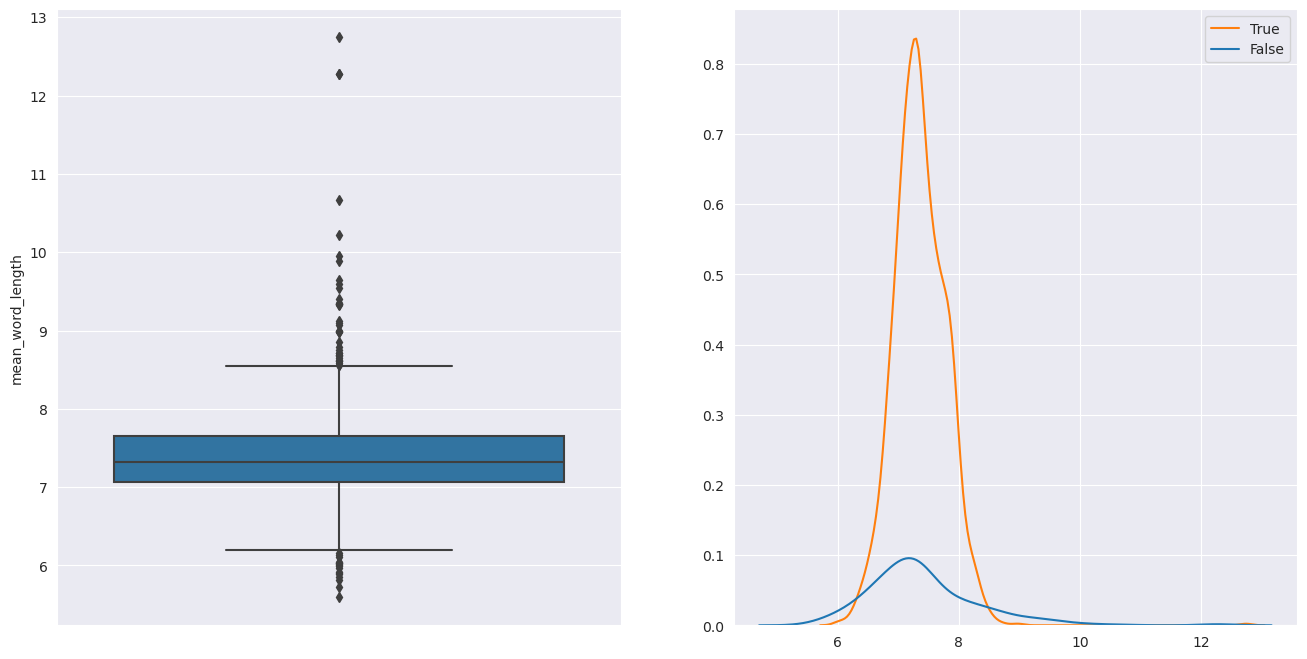

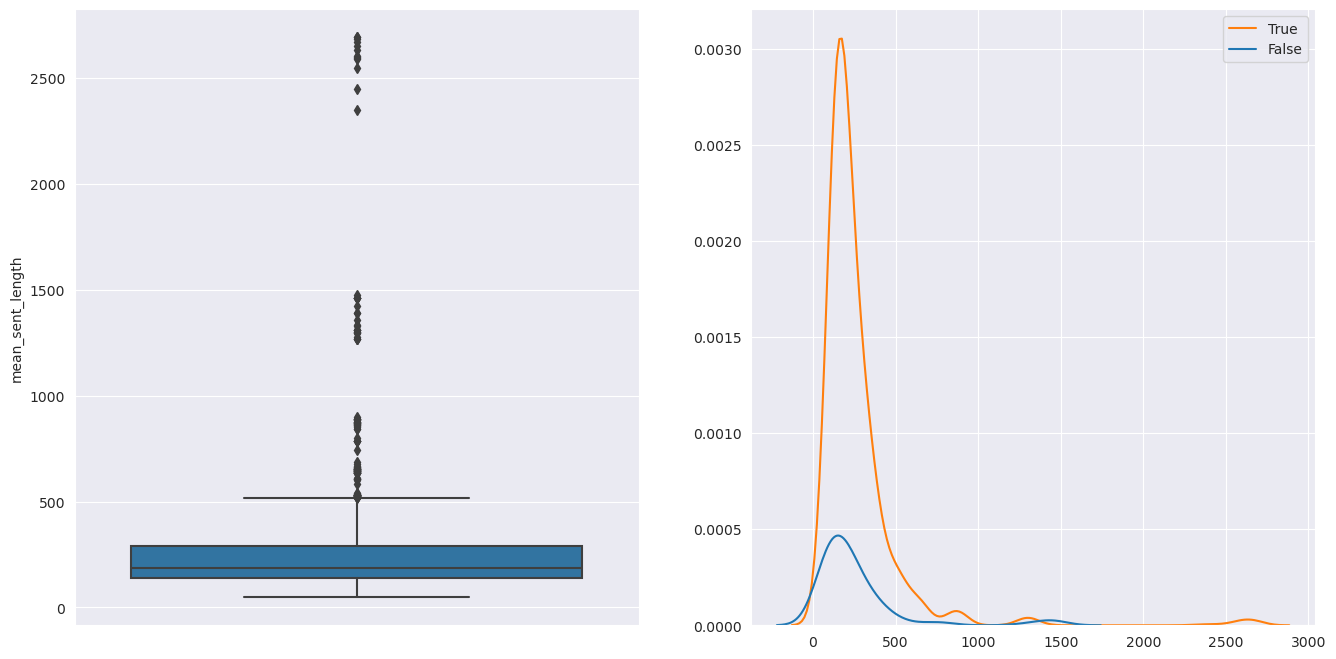

In [26]:
features = train_df.columns.tolist()[6:-1]
for feature in features:
    visualize(feature, 'extracted')

## Term frequency analysis

In [27]:
df = train_df[['id', 'text', 'label', 'extracted']]
df.head()

,id,text,label,extracted
0,809436509,Извещение о проведении открытого конкурса в эл...,обеспечение исполнения контракта,True
1,854885310,ТРЕБОВАНИЯ К СОДЕРЖАНИЮ ЗАЯВКИ участника запро...,обеспечение исполнения контракта,True
2,4382157,Извещение о проведении электронного аукциона д...,обеспечение исполнения контракта,True
3,184555082,Извещение о проведении электронного аукциона д...,обеспечение исполнения контракта,True
4,211645258,Извещение о проведении электронного аукциона д...,обеспечение исполнения контракта,True


In [28]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1799 entries, 0 to 1798
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         1799 non-null   int64 
 1   text       1799 non-null   object
 2   label      1799 non-null   object
 3   extracted  1799 non-null   bool  
dtypes: bool(1), int64(1), object(2)
memory usage: 44.0+ KB


In [29]:
def clean(sample):
    sample = sample.lower()
    sample = re.sub('[^а-я a-z A-Z 0-9-]+', '', sample)
    sample = " ".join([word for word in sample.split() if word not in stopwords.words('russian')])
    
    return sample

In [30]:
df['cleaned_text'] = df['text'].apply(clean)
df.head()

,id,text,label,extracted,cleaned_text
0,809436509,Извещение о проведении открытого конкурса в эл...,обеспечение исполнения контракта,True,извещение проведении открытого конкурса электр...
1,854885310,ТРЕБОВАНИЯ К СОДЕРЖАНИЮ ЗАЯВКИ участника запро...,обеспечение исполнения контракта,True,требования содержанию заявки участника запроса...
2,4382157,Извещение о проведении электронного аукциона д...,обеспечение исполнения контракта,True,извещение проведении электронного аукциона зак...
3,184555082,Извещение о проведении электронного аукциона д...,обеспечение исполнения контракта,True,извещение проведении электронного аукциона зак...
4,211645258,Извещение о проведении электронного аукциона д...,обеспечение исполнения контракта,True,извещение проведении электронного аукциона зак...


In [31]:
df['cleaned_text'][0]

'извещение проведении открытого конкурса электронной форме закупки 0328300032822000806 общая информация номер извещения 0328300032822000806 наименование объекта закупки поставка продуктов питания способ определения поставщика подрядчика исполнителя открытый конкурс бль порядок внесения денежных средств качестве обеспечения заявки участие закупке также условия гарантии обеспечение заявки участие закупке предоставляться участником закупки виде денежных средств независимой гарантии предусмотренной ст 45 федерального закона 44-фз выбор способа обеспечения осуществляется участником закупки самостоятельно срок действия независимой гарантии должен составлять менее месяца даты окончания срока подачи заявок обеспечение заявки участие закупке предоставляется соответствии ч 5 ст 44 федерального закона 44-фз условия независимой гарантии соответствии ст 45 федерального закона 44-фз реквизиты счета соответствии п16 ч 1 ст 42 закона 44-фз номер расчтного счта 00000000000000000000 номер лицевого счта 

In [32]:
corpus = []
for i in trange(df.shape[0], ncols=150, nrows=10, colour='green', smoothing=0.8):
    corpus += df.loc[i, 'cleaned_text'].split()
len(corpus)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 1799/1799 [00:00<00:00, 25242.80it/s]


400186

In [33]:
mostCommon = Counter(corpus).most_common(10)
mostCommon

[('исполнения', 8440),
 ('контракта', 7853),
 ('обеспечения', 6884),
 ('договора', 6012),
 ('закупки', 4892),
 ('обеспечение', 4664),
 ('обязательств', 4155),
 ('соответствии', 3257),
 ('гарантии', 3116),
 ('закона', 2942)]

In [34]:
words = []
freq = []
for word, count in mostCommon:
    words.append(word)
    freq.append(count)

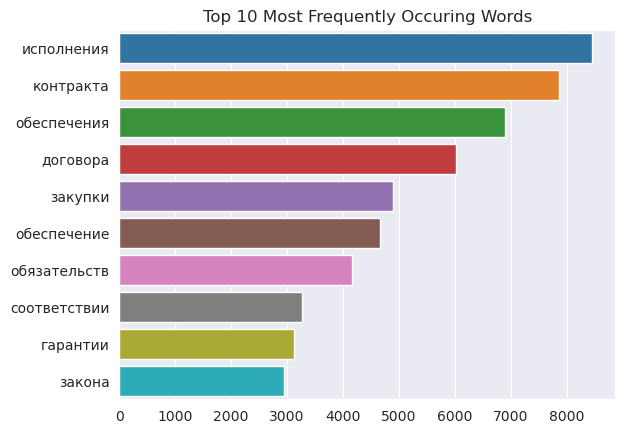

In [35]:
sns.barplot(x=freq, y=words)
plt.title('Top 10 Most Frequently Occuring Words')
plt.show()

## n-gram frequency

In [36]:
cv = CountVectorizer(ngram_range=(2,2))
bigrams = cv.fit_transform(df['text'])

In [37]:
count_values = bigrams.toarray().sum(axis=0)
ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv.vocabulary_.items()], reverse = True))
ngram_freq.columns = ["frequency", "ngram"]

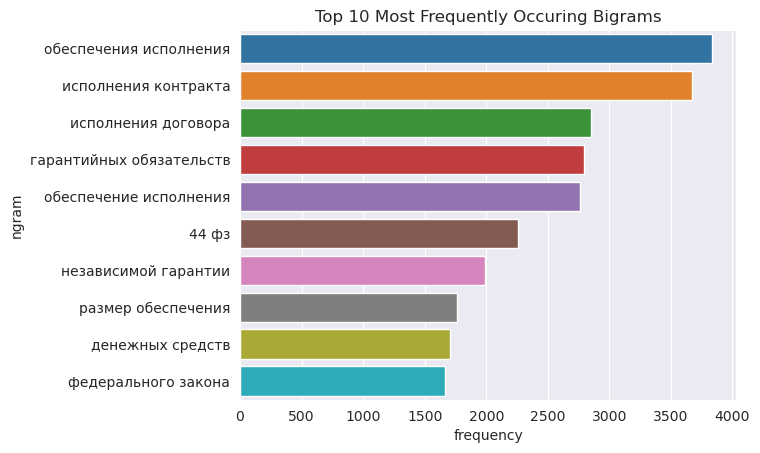

In [38]:
sns.barplot(x=ngram_freq['frequency'][:10], y=ngram_freq['ngram'][:10])
plt.title('Top 10 Most Frequently Occuring Bigrams')
plt.show()

In [39]:
cv1 = CountVectorizer(ngram_range=(3,3))
trigrams = cv1.fit_transform(df['text'])
count_values = trigrams.toarray().sum(axis=0)
ngram_freq = pd.DataFrame(sorted([(count_values[i], k) for k, i in cv1.vocabulary_.items()], reverse = True))
ngram_freq.columns = ["frequency", "ngram"]

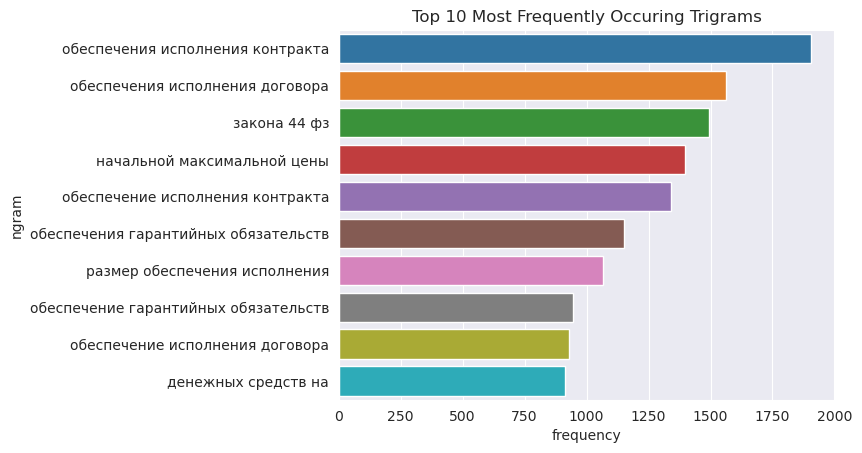

In [40]:
sns.barplot(x=ngram_freq['frequency'][:10], y=ngram_freq['ngram'][:10])
plt.title('Top 10 Most Frequently Occuring Trigrams')
plt.show()

# Feature extraction

In [41]:
device = torch.device('cuda')

bert = AutoModel.from_pretrained(TOKENIZER_CHECKPOINT, output_hidden_states=True).to(device)
tokenizer = AutoTokenizer.from_pretrained(TOKENIZER_CHECKPOINT)

Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.decoder.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [42]:
def feature_extractor(text):
    kwargs = {'return_tensors': 'pt', 'padding': 'max_length', 'truncation': True, 'max_length': SEQ_LEN}
    ids = tokenizer(text, **kwargs).to(device).input_ids
    return bert(ids).last_hidden_state.detach() # [1, max_length, 768]

In [43]:
features = feature_extractor(train[0]['text'])
features.shape

torch.Size([1, 512, 768])

# BiDAF

### Получаем фичи тех предложений, которые соответствуют лейблам 

In [44]:
def get_label_features(label):
    '''Получает фичи из всех отрывков, соответсвующих label'''
    texts = [x['extracted_part']['text'][0] for x in train if x['label'] == label and len(x['extracted_part']['text'][0]) != 0]
    sum = 0
    for i in tqdm(range(len(texts))):
        sum += feature_extractor(texts[i])
    return sum / len(texts)

In [45]:
contract_security_features = get_label_features(CONTRACT_SECURITY_LABEL)
contract_security_features.shape

100%|██████████| 984/984 [00:31<00:00, 30.99it/s]


torch.Size([1, 512, 768])

In [46]:
warranty_coverage_features = get_label_features(WARRANTY_COVERAGE_LABEL)
warranty_coverage_features.shape

100%|██████████| 508/508 [00:16<00:00, 30.36it/s]


torch.Size([1, 512, 768])

In [47]:
features = {0: contract_security_features, 1: warranty_coverage_features}

In [48]:
class BiDAF(nn.Module):
    def __init__(self, hidden_size):
        super(BiDAF, self).__init__()
        # Attention Flow Layer
        self.att_weight_c = nn.Linear(hidden_size * 2, 1)
        self.att_weight_q = nn.Linear(hidden_size * 2, 1)
        self.att_weight_cq = nn.Linear(hidden_size * 2, 1)

        # Modeling Layer
        self.modeling_LSTM1 = nn.LSTM(input_size=hidden_size * 8,
                                   hidden_size=hidden_size,
                                   bidirectional=True,
                                   batch_first=True)

        self.modeling_LSTM2 = nn.LSTM(input_size=hidden_size * 2,
                                   hidden_size=hidden_size,
                                   bidirectional=True,
                                   batch_first=True)

        # Output Layer
        self.p1_weight_g = nn.Linear(hidden_size * 8, 1)
        self.p1_weight_m = nn.Linear(hidden_size * 2, 1)
        self.p2_weight_g = nn.Linear(hidden_size * 8, 1)
        self.p2_weight_m = nn.Linear(hidden_size * 2, 1)

        self.output_LSTM = nn.LSTM(input_size=hidden_size * 2,
                                hidden_size=hidden_size,
                                bidirectional=True,
                                batch_first=True)

    def forward(self, c, q):
        def att_flow_layer(c, q):
            """
            :param c: (batch, SEQ_LEN, 768)
            :param q: (batch, SEQ_LEN, 768)
            :return: (batch, SEQ_LEN, SEQ_LEN)
            """
            global first
            c_len = c.size(1)
            q_len = q.size(1)

            cq = []
            for i in range(q_len):
                #(batch, 1, hidden_size * 2)
                qi = q.select(1, i).unsqueeze(1)
                #(batch, c_len, 1)
                ci = self.att_weight_cq(c * qi).squeeze()
                cq.append(ci)
            # (batch, c_len, q_len)
            cq = torch.stack(cq, dim=-1)

            # (batch, c_len, q_len)
            s = self.att_weight_c(c).expand(-1, -1, q_len) + \
                self.att_weight_q(q).permute(0, 2, 1).expand(-1, c_len, -1) + \
                cq

            # (batch, c_len, q_len)
            a = F.softmax(s, dim=2)
            # (batch, c_len, q_len) * (batch, q_len, hidden_size * 2) -> (batch, c_len, hidden_size * 2)
            c2q_att = torch.bmm(a, q)
            # (batch, 1, c_len)
            b = F.softmax(torch.max(s, dim=2)[0], dim=1).unsqueeze(1)
            # (batch, 1, c_len) * (batch, c_len, hidden_size * 2) -> (batch, hidden_size * 2)
            q2c_att = torch.bmm(b, c).squeeze()
            # (batch, c_len, hidden_size * 2) (tiled)
            if q2c_att.dim() == 1:
                q2c_att = q2c_att.unsqueeze(0)
            q2c_att = q2c_att.unsqueeze(1).expand(-1, c_len, -1)
                
            # (batch, c_len, hidden_size * 8)
            x = torch.cat([c, c2q_att, c * c2q_att, c * q2c_att], dim=-1)
            return x

        def output_layer(g, m):
            """
            :param g: (batch, c_len, hidden_size * 8)
            :param m: (batch, c_len ,hidden_size * 2)
            :return: p1: (batch, c_len), p2: (batch, c_len)
            """
            # (batch, c_len)
            p1 = (self.p1_weight_g(g) + self.p1_weight_m(m)).squeeze()
            # (batch, c_len, hidden_size * 2)
            m2 = self.output_LSTM(m)[0]
            # (batch, c_len)
            p2 = (self.p2_weight_g(g) + self.p2_weight_m(m2)).squeeze()

            return p1, p2

        # Attention Flow Layer
        g = att_flow_layer(c, q)
        # Modeling Layer
        m = self.modeling_LSTM2(self.modeling_LSTM1(g)[0])[0]
        # Output Layer
        p1, p2 = output_layer(g, m)

        # (batch, c_len), (batch, c_len)
        if p1.dim() == 1:
            return p1.unsqueeze(0), p2.unsqueeze(0)
        return p1, p2

### Создание датасета

In [49]:
def collate_fn(batch):
    '''Создает бачи для DataLoader'''
    texts_tensor = torch.zeros((len(batch), SEQ_LEN, EMB_DIM))
    queries = torch.zeros((len(batch), SEQ_LEN, EMB_DIM))
    answer_start_in_tokens = torch.zeros((len(batch),))
    answer_end_in_tokens = torch.zeros((len(batch),))
    
    for i, x in enumerate(batch):
        texts_tensor[i] = feature_extractor(x['text'])
        queries[i] = features[int(x['label'] == WARRANTY_COVERAGE_LABEL)]
        start = x['extracted_part']['answer_start'][0]
        end = x['extracted_part']['answer_end'][0]
        
        tokens = tokenizer.tokenize(x['text'][:start])
        answer_start_in_tokens[i] = len(tokens)
        tokens = tokenizer.tokenize(x['text'][start:end])
        answer_end_in_tokens[i] = answer_start_in_tokens[i] + len(tokens)
    
    return {'texts': texts_tensor,
            'queries': queries,
            'answer_starts': answer_start_in_tokens.type(torch.LongTensor),
            'answer_ends': answer_end_in_tokens.type(torch.LongTensor)}

In [50]:
batch = collate_fn(train[:2])
batch['queries'].shape

torch.Size([2, 512, 768])

In [51]:
class DocumentsDataset(Dataset):
    def __init__(self, data):
        data = np.array(data)
        indicies = shuffle(np.arange(data.shape[0]))
        self.data = data[indicies]
        
    def __getitem__(self, idx):
        return self.data[idx]

    def __len__(self):
        return self.data.shape[0]

dataset = DocumentsDataset(train)

train_size, val_size = int(.7 * len(dataset)), int(.1 * len(dataset))
train_data, valid_data, test_data = random_split(dataset, [train_size, val_size, len(dataset) - train_size - val_size])

print(f"Number of training examples: {len(train_data)}")
print(f"Number of validation examples: {len(valid_data)}")
print(f"Number of testing examples: {len(test_data)}")

Number of training examples: 1259
Number of validation examples: 179
Number of testing examples: 361


In [52]:
train_loader = DataLoader(train_data, collate_fn=collate_fn, batch_size=BATCH_SIZE)
valid_loader = DataLoader(valid_data, collate_fn=collate_fn, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_data, collate_fn=collate_fn, batch_size=BATCH_SIZE)

In [53]:
for x in train_loader:
    print(x['texts'].shape)
    print(x['queries'].shape)
    break

torch.Size([4, 512, 768])
torch.Size([4, 512, 768])


### Определение функций для обучения

In [54]:
def count_accuracy(output, answers):
    return torch.sum(torch.sum(output == answers, axis=1) == output.shape[1])

In [55]:
def count_acc(p1, p2, answer_starts, answer_ends):
    preds_starts = torch.argmax(p1, axis=1).unsqueeze(1)
    preds_ends = torch.argmax(p2, axis=1).unsqueeze(1)
    
    output = torch.cat([preds_starts, preds_ends], axis=1)
    answers = torch.cat([answer_starts.unsqueeze(1), answer_ends.unsqueeze(1)], axis=1)

    return count_accuracy(output, answers)

In [56]:
def batch_to_device(batch, device):
    batch['texts'] = batch['texts'].to(device)
    batch['queries'] = batch['queries'].to(device)
    batch['answer_starts'] = batch['answer_starts'].to(device)
    batch['answer_ends'] = batch['answer_ends'].to(device)
    return batch

In [57]:
def fit_epoch(model, train_loader, criterion, optimizer):
    model.train()
    running_loss = running_acc = processed_size = 0.0
  
    for batch in train_loader:
        batch = batch_to_device(batch, device)
        contexts = batch['texts']
        queries = batch['queries']
        answer_starts = batch['answer_starts']
        answer_ends = batch['answer_ends']

        optimizer.zero_grad()
        if model.__class__.__name__ == 'BiDAF':
            p1, p2 = model(contexts, queries)
            loss = criterion(p1, answer_starts) + criterion(p2, answer_ends)
            acc = count_acc(p1, p2, answer_starts, answer_ends).cpu().numpy()
        else:
            output = model(contexts, queries)
            answers = torch.cat([answer_starts.unsqueeze(1), answer_ends.unsqueeze(1)], axis=1)
            answers = (torch.sum(answers == 0, axis=1) != 2).type(torch.LongTensor).to(device)
            loss = criterion(output, answers)
            preds = (output.cpu().detach().numpy()[:,1] > 0.5).astype(int)
            acc = np.sum(preds == answers.cpu().detach().numpy())
        loss.backward()
        optimizer.step()
        
        running_loss += loss.item() * contexts.size(0)
        running_acc += acc
        processed_size += contexts.size(0)
    
    train_loss = running_loss / processed_size
    train_acc = running_acc / processed_size
    return train_loss, train_acc

In [58]:
def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = running_acc = processed_size = 0.0

    for batch in val_loader:
        batch = batch_to_device(batch, device)
        contexts = batch['texts']
        queries = batch['queries']
        answer_starts = batch['answer_starts']
        answer_ends = batch['answer_ends']

        with torch.set_grad_enabled(False):
            if model.__class__.__name__ == 'BiDAF':
                p1, p2 = model(contexts, queries)
                loss = criterion(p1, answer_starts) + criterion(p2, answer_ends)
                acc = count_acc(p1, p2, answer_starts, answer_ends).cpu().numpy()
            else:
                output = model(contexts, queries)
                answers = torch.cat([answer_starts.unsqueeze(1), answer_ends.unsqueeze(1)], axis=1)
                answers = (torch.sum(answers == 0, axis=1) != 2).type(torch.LongTensor).to(device)
                loss = criterion(output, answers)
                preds = (output.cpu().detach().numpy()[:,1] > 0.5).astype(int)
                acc = np.sum(preds == answers.cpu().detach().numpy())

        running_loss += loss.item() * contexts.size(0)
        running_acc += acc
        processed_size += contexts.size(0)
    
    val_loss = running_loss / processed_size
    val_acc = running_acc / processed_size
    return val_loss, val_acc

In [59]:
def fit(train_loader, val_loader, model, epochs):
    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"
    
    criterion = nn.CrossEntropyLoss()

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.AdamW(model.parameters())
        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)
            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))
            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            
    return history, opt

#### Обучение

In [60]:
if TRAIN_MODE:
    main_model = BiDAF(HIDDEN_SIZE).to(device)
    history, optimizer = fit(train_loader, valid_loader, main_model, epochs=10)

epoch:   0%|          | 0/10 [00:00<?, ?it/s]

loss 2.089519400193968


epoch:  10%|█         | 1/10 [02:16<20:25, 136.17s/it]


Epoch 001 train_loss: 2.0895     val_loss 1.7806 train_acc 0.6529 val_acc 0.6536
loss 1.1195911307167483


epoch:  20%|██        | 2/10 [04:33<18:14, 136.81s/it]


Epoch 002 train_loss: 1.1196     val_loss 2.0511 train_acc 0.7665 val_acc 0.6089
loss 0.8598605611023505


epoch:  30%|███       | 3/10 [06:50<15:58, 136.95s/it]


Epoch 003 train_loss: 0.8599     val_loss 1.2693 train_acc 0.8173 val_acc 0.6872
loss 0.7069960376223723


epoch:  40%|████      | 4/10 [09:07<13:41, 136.99s/it]


Epoch 004 train_loss: 0.7070     val_loss 1.4033 train_acc 0.8411 val_acc 0.7095
loss 0.6044302253407479


epoch:  50%|█████     | 5/10 [11:24<11:24, 136.83s/it]


Epoch 005 train_loss: 0.6044     val_loss 1.3214 train_acc 0.8451 val_acc 0.6927
loss 0.5216668862150428


epoch:  60%|██████    | 6/10 [13:40<09:06, 136.60s/it]


Epoch 006 train_loss: 0.5217     val_loss 1.2552 train_acc 0.8689 val_acc 0.7430
loss 0.45883537217025216


epoch:  70%|███████   | 7/10 [15:56<06:49, 136.47s/it]


Epoch 007 train_loss: 0.4588     val_loss 1.2907 train_acc 0.8872 val_acc 0.7039
loss 0.4845011572654428


epoch:  80%|████████  | 8/10 [18:13<04:33, 136.58s/it]


Epoch 008 train_loss: 0.4845     val_loss 1.1517 train_acc 0.8737 val_acc 0.7207
loss 0.3648214151376727


epoch:  90%|█████████ | 9/10 [20:29<02:16, 136.51s/it]


Epoch 009 train_loss: 0.3648     val_loss 1.0983 train_acc 0.9063 val_acc 0.7542
loss 0.30197395532077476


epoch: 100%|██████████| 10/10 [22:45<00:00, 136.59s/it]


Epoch 010 train_loss: 0.3020     val_loss 1.0654 train_acc 0.9142 val_acc 0.7654


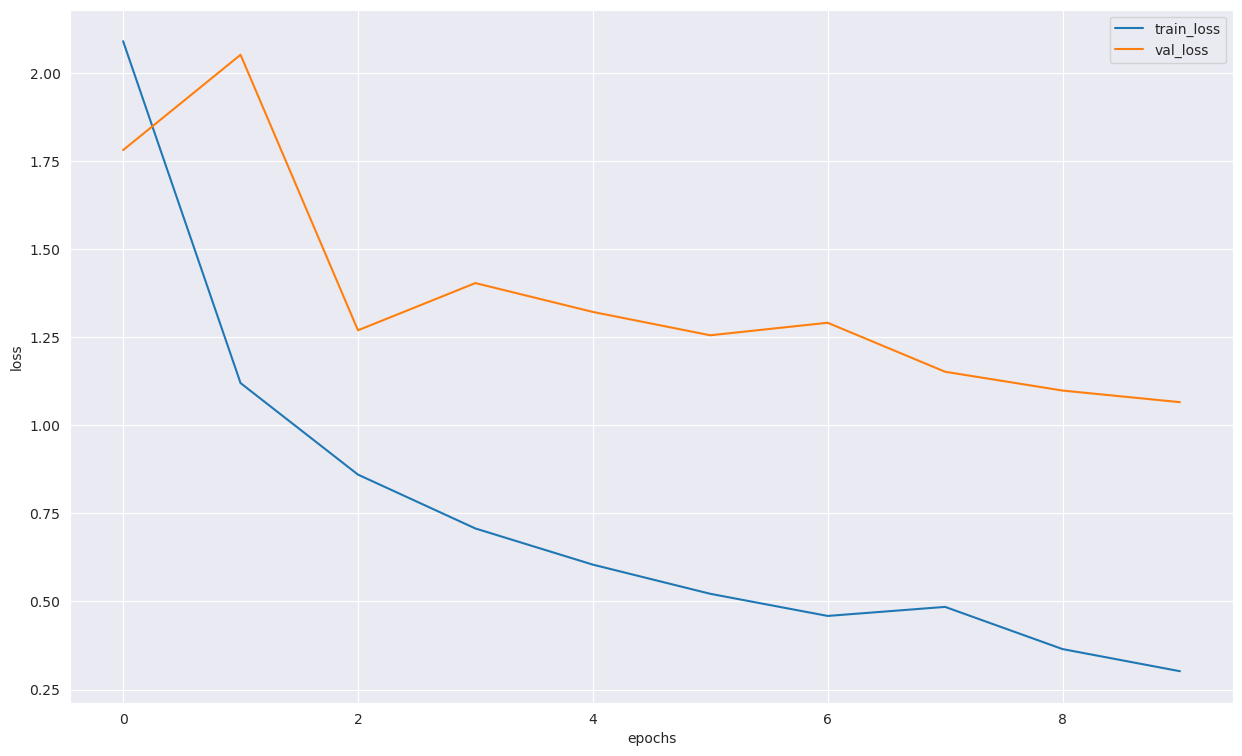

In [61]:
def show_history(history):
    loss, acc, val_loss, val_acc = zip(*history)
    plt.figure(figsize=(15, 9))
    plt.plot(loss, label="train_loss")
    plt.plot(val_loss, label="val_loss")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.show()
if TRAIN_MODE:
    show_history(history)

#### Сохранение, загрузка модели bidaf_10epochs

In [73]:
if TRAIN_MODE:
    torch.save({
                'epoch': 10,
                'model_state_dict': main_model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict()
                }, BIDAF_10EPOCHS_SAVE_TO_PATH)

In [75]:
if not TRAIN_MODE:
    main_model = BiDAF(HIDDEN_SIZE).to(device)
    optimizer = torch.optim.AdamW(main_model.parameters())

    checkpoint = torch.load(BIDAF_10EPOCHS_LOAD_FROM_PATH)
    main_model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    bidaf_epoch = checkpoint['epoch']

In [76]:
model_for_cls = BiDAF(HIDDEN_SIZE).to(device)
model_for_cls.load_state_dict(main_model.state_dict().copy())

<All keys matched successfully>

In [77]:
weights_count = 0
for param in main_model.parameters():
    weights_count += len(param.view(-1))
print(f'{weights_count // 1_000_000} millions weigths')

17 millions weigths


### Создание классификатора, для проверки наличия extracted part в тексте

In [78]:
class ExtractedPartClassifier(nn.Module):
    def __init__(self, bidaf):
        super(ExtractedPartClassifier, self).__init__()
        self.bidaf = bidaf
        self.linear1 = nn.Linear(1024, 128)
        self.relu = nn.ReLU()
        self.linear2 = nn.Linear(128, 16)
        self.linear3 = nn.Linear(16, 2)
    
    def forward(self, c, q):
        p1, p2 = self.bidaf(c, q)
        x = torch.cat([p1, p2], axis=1)
        x = self.relu(self.linear1(x))
        x = self.relu(self.linear2(x))
        return self.linear3(x)

#### Сделаем сбалансированный датасет для классификатора

In [79]:
def get_balanced_dataset_from(loader):
    '''Создает датасет с равными долями объектов с extracted_part и без extracted_part'''
    class0_items = []
    class0_items_count = 0
    class1_items = []
    for batch in tqdm(loader):
        boundaries = torch.cat([batch['answer_starts'].unsqueeze(1), batch['answer_ends'].unsqueeze(1)], axis=1)
        for i, x in enumerate(boundaries):
            if x[0] == 0 and x[1] == 0:
                class0_items.append({
                    'text': batch['texts'][i],
                    'query': batch['queries'][i],
                    'answer_start': 0, 
                    'answer_end': 0
                })
                class0_items_count += 1
            else:
                if class0_items_count > len(class1_items):
                    class1_items.append({
                        'text': batch['texts'][i],
                        'query': batch['queries'][i],
                        'answer_start': x[0], 
                        'answer_end': x[1]
                    })

    print(f'class0_len: {len(class0_items)}, class1_len: {len(class1_items)}')
    return DocumentsDataset(class0_items + class1_items)

In [80]:
def collate_fn_for_tokenized_texts(batch):
    '''Создает бачи из данных, уже обработанных другим DataLoader-ом'''
    texts_tensor = torch.zeros((len(batch), SEQ_LEN, EMB_DIM))
    queries = torch.zeros((len(batch), SEQ_LEN, EMB_DIM))
    answer_start_in_tokens = torch.zeros((len(batch),))
    answer_end_in_tokens = torch.zeros((len(batch),))
    
    for i, x in enumerate(batch):
        texts_tensor[i] = x['text']
        queries[i] = x['query']
        answer_start_in_tokens[i] = x['answer_start']
        answer_end_in_tokens[i] = x['answer_end']
    
    return {'texts': texts_tensor,
            'queries': queries, 
            'answer_starts': answer_start_in_tokens.type(torch.LongTensor), 
            'answer_ends': answer_end_in_tokens.type(torch.LongTensor)}

In [69]:
balanced_dataloader_train = DataLoader(
    get_balanced_dataset_from(train_loader), 
    collate_fn=collate_fn_for_tokenized_texts, 
    batch_size=BATCH_SIZE)

balanced_dataloader_valid = DataLoader(
    get_balanced_dataset_from(valid_loader), 
    collate_fn=collate_fn_for_tokenized_texts, 
    batch_size=BATCH_SIZE)

100%|██████████| 315/315 [00:48<00:00,  6.47it/s]


class0_len: 204, class1_len: 204


100%|██████████| 45/45 [00:07<00:00,  6.41it/s]

class0_len: 35, class1_len: 35


#### Обучим классификатор на сбалансированном датасете

In [81]:
CLS_EPOCH = 4

In [82]:
if TRAIN_MODE:
    cls = ExtractedPartClassifier(model_for_cls).to(device)
    history, cls_optimizer = fit(
        balanced_dataloader_train, balanced_dataloader_valid, cls, epochs=CLS_EPOCH)

epoch:   0%|          | 0/4 [00:00<?, ?it/s]

loss 0.34650011509211254


epoch:  25%|██▌       | 1/4 [00:27<01:22, 27.65s/it]


Epoch 001 train_loss: 0.3465     val_loss 0.0215 train_acc 0.7868 val_acc 0.9857
loss 0.028432361059342725


epoch:  50%|█████     | 2/4 [00:55<00:55, 27.75s/it]


Epoch 002 train_loss: 0.0284     val_loss 0.0000 train_acc 0.9804 val_acc 0.9857
loss 0.2837712884110997


epoch:  75%|███████▌  | 3/4 [01:22<00:27, 27.60s/it]


Epoch 003 train_loss: 0.2838     val_loss 0.0000 train_acc 0.9681 val_acc 1.0000
loss 0.006415260901671751


epoch: 100%|██████████| 4/4 [01:50<00:00, 27.61s/it]


Epoch 004 train_loss: 0.0064     val_loss 0.0004 train_acc 1.0000 val_acc 0.9857


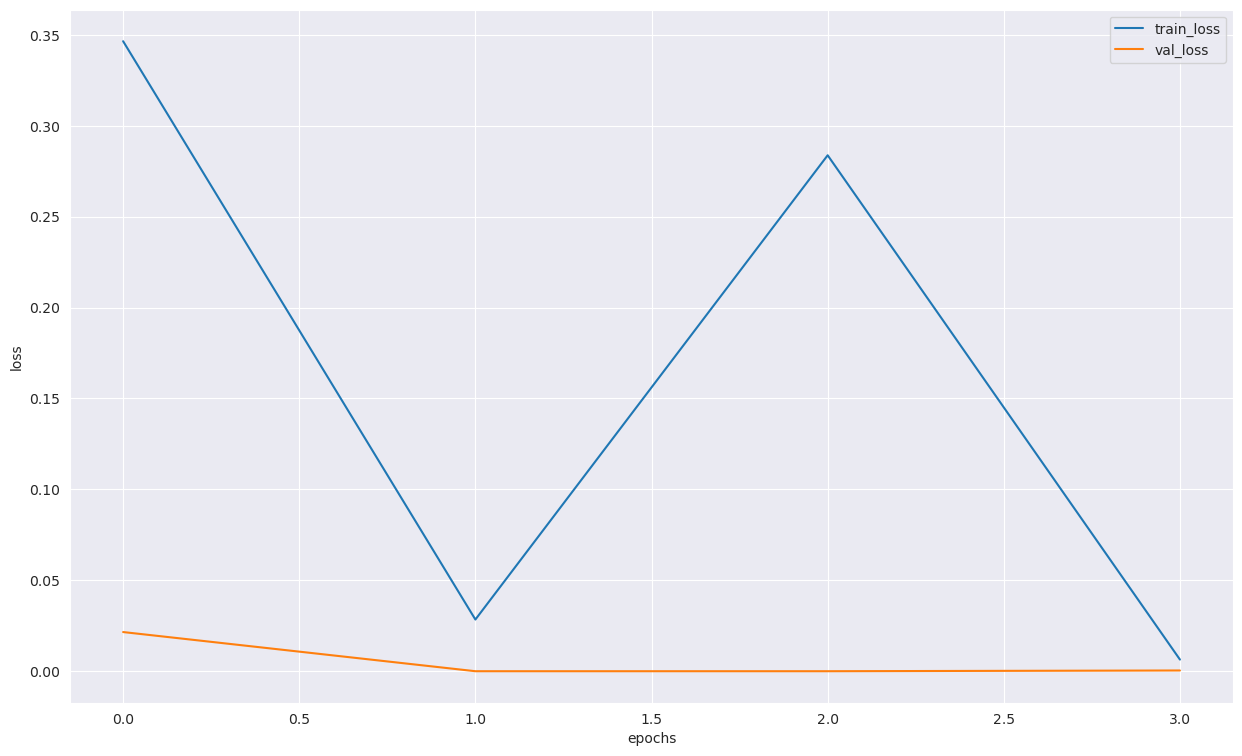

In [83]:
if TRAIN_MODE:
    show_history(history)

#### Сохранение, загрузка классификатора

In [84]:
if TRAIN_MODE:
    torch.save({
                'epoch': CLS_EPOCH,
                'model_state_dict': cls.state_dict(),
                'optimizer_state_dict': cls_optimizer.state_dict()
                }, BIDAF_CLS_SAVE_TO_PATH)

In [85]:
# Загрузка модели
if not TRAIN_MODE:
    cls = ExtractedPartClassifier(BiDAF(HIDDEN_SIZE).to(device)).to(device)
    cls_optimizer = torch.optim.AdamW(cls.parameters())

    checkpoint = torch.load(BIDAF_CLS_LOAD_FROM_PATH)
    cls.load_state_dict(checkpoint['model_state_dict'])
    cls_optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    cls_epoch = checkpoint['epoch']

### Дообучение BiDAF на датасете без объектов с отсутствующими extracted part

Теперь, когда у нас есть классификатор, мы можем заострить внимание модели на объектах, у которых есть extracted part. На инференсе будем для объектов без extracted part заменять отметы модели на нули.

In [86]:
def get_ds_with_extracted_part_from(loader):
    '''Пропускает все объекты без extracted part и создает датасет из остальных'''
    items = []
    for batch in tqdm(loader):
        boundaries = torch.cat([batch['answer_starts'].unsqueeze(1), batch['answer_ends'].unsqueeze(1)], axis=1)
        for i, x in enumerate(boundaries):
            if x[0] == 0 and x[1] == 0:
                continue
            items.append({
                'text': batch['texts'][i],
                'query': batch['queries'][i],
                'answer_start': x[0], 
                'answer_end': x[1]
                })

    print(f'items_len: {len(items)}')
    return DocumentsDataset(items)

In [87]:
dl_with_extracted_part_train = DataLoader(
    get_ds_with_extracted_part_from(train_loader), 
    collate_fn=collate_fn_for_tokenized_texts, 
    batch_size=BATCH_SIZE)

dl_with_extracted_part_valid = DataLoader(
    get_ds_with_extracted_part_from(valid_loader), 
    collate_fn=collate_fn_for_tokenized_texts, 
    batch_size=BATCH_SIZE)

100%|██████████| 315/315 [00:49<00:00,  6.38it/s]


items_len: 1055


100%|██████████| 45/45 [00:07<00:00,  6.36it/s]

items_len: 144


#### Дообучение модели

In [88]:
if TRAIN_MODE:
    MAIN_MODEL_EPOCH = 5
    history, main_model_optimizer = fit(
        dl_with_extracted_part_train, 
        dl_with_extracted_part_valid, 
        main_model, 
        epochs=MAIN_MODEL_EPOCH)

epoch:   0%|          | 0/5 [00:00<?, ?it/s]

loss 0.7382294504263248


epoch:  20%|██        | 1/5 [01:09<04:36, 69.09s/it]


Epoch 001 train_loss: 0.7382     val_loss 0.6617 train_acc 0.8445 val_acc 0.8403
loss 0.5567556339082136


epoch:  40%|████      | 2/5 [02:18<03:27, 69.15s/it]


Epoch 002 train_loss: 0.5568     val_loss 0.8125 train_acc 0.8758 val_acc 0.8125
loss 0.45238685517337934


epoch:  60%|██████    | 3/5 [03:27<02:18, 69.22s/it]


Epoch 003 train_loss: 0.4524     val_loss 0.7678 train_acc 0.8929 val_acc 0.8194
loss 0.4115822673144075


epoch:  80%|████████  | 4/5 [04:36<01:09, 69.25s/it]


Epoch 004 train_loss: 0.4116     val_loss 0.7748 train_acc 0.9062 val_acc 0.7847
loss 0.307795463083974


epoch: 100%|██████████| 5/5 [05:46<00:00, 69.22s/it]


Epoch 005 train_loss: 0.3078     val_loss 0.8774 train_acc 0.9261 val_acc 0.7708


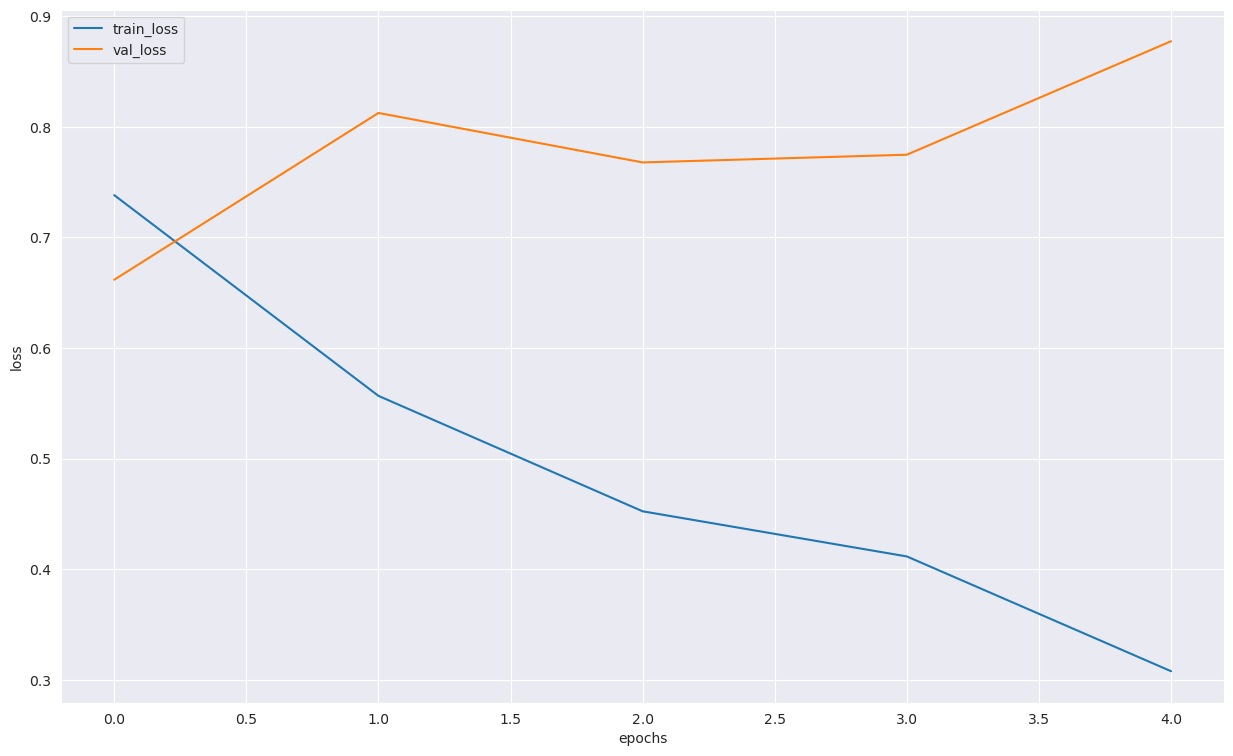

In [89]:
if TRAIN_MODE:
    show_history(history)

#### Сохранение, загрузка модели "main_model"

In [90]:
if TRAIN_MODE:
    torch.save({
                'epoch': MAIN_MODEL_EPOCH,
                'model_state_dict': main_model.state_dict(),
                'optimizer_state_dict': main_model_optimizer.state_dict()
                }, BIDAF_MAIN_MODEL_SAVE_TO_PATH)

In [91]:
if not TRAIN_MODE:
    main_model = BiDAF(HIDDEN_SIZE).to(device)
    main_model_optimizer = torch.optim.AdamW(main_model.parameters())

    checkpoint = torch.load(BIDAF_MAIN_MODEL_LOAD_FROM_PATH)
    main_model.load_state_dict(checkpoint['model_state_dict'])
    main_model_optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    bidaf_epoch = checkpoint['epoch']

### Проверка на тесте

In [92]:
def predict(model, cls, test_loader, offset_mapping=False):
    with torch.no_grad():
        starts, ends = [], []
        extracted_part_predictions = []
        offset_mappings = []
        model.eval()
        cls.eval()
    
        for batch in tqdm(test_loader):
            contexts = batch['texts'].to(device)
            queries = batch['queries'].to(device)
            if offset_mapping:
                offset_mappings.append(batch['offset_mappings'])

            output = cls(contexts, queries)
            preds = (output.cpu().detach().numpy()[:,1] > 0.5).astype(int)
            extracted_part_predictions.extend(preds)
            
            p1, p2 = model(contexts, queries)
            p1, p2 = p1.cpu().detach(), p2.cpu().detach()
            
            starts.append(p1)
            ends.append(p2)
            
    starts = torch.argmax(torch.cat(starts, axis=0), axis=1)
    ends = torch.argmax(torch.cat(ends, axis=0), axis=1)
    
    for i in range(len(extracted_part_predictions)):
        if not extracted_part_predictions[i]:
            starts[i], ends[i] = 0, 0
    
    output = torch.cat([starts.unsqueeze(1), ends.unsqueeze(1)], axis=1)
    if offset_mapping:
        return output, torch.cat(offset_mappings, axis=0)
    return output

In [93]:
def get_answers(test_loader):
    starts, ends = [], []
    for batch in tqdm(test_loader):
        starts.append(batch['answer_starts'])
        ends.append(batch['answer_ends'])
    
    return torch.cat([torch.cat(starts, axis=0).unsqueeze(1), 
                      torch.cat(ends, axis=0).unsqueeze(1)], axis=1)

In [94]:
output = predict(main_model, cls, test_loader)
answers = get_answers(test_loader)

100%|██████████| 91/91 [00:13<00:00,  6.65it/s]


In [95]:
print(f'test accuracy: {(count_accuracy(output, answers) / len(output)).item()}')

test accuracy: 0.8365650773048401


### Подготовка dataloader-а для инференса

In [96]:
def collate_fn_for_test(batch):
    '''Функция учитывает отсутствие ответов и сохраняет offset_mapping для восстановления ответа'''
    texts_tensor = torch.zeros((len(batch), SEQ_LEN, EMB_DIM))
    queries = torch.zeros((len(batch), SEQ_LEN, EMB_DIM))
    offset_mappings = torch.zeros((len(batch), SEQ_LEN, 2))
    
    for i, x in enumerate(batch):
        kwargs = {'return_tensors':'pt', 
                  'return_offsets_mapping': True, 
                  'padding':'max_length', 
                  'truncation':True, 
                  'max_length':SEQ_LEN}
        res = tokenizer(x['text'], **kwargs).to(device)
        
        offset_mappings[i] = res.offset_mapping
        texts_tensor[i] = bert(res.input_ids).last_hidden_state.detach() # [1, max_length, 768]
        queries[i] = features[int(x['label'] == 'обеспечение гарантийных обязательств')]

    return {'texts': texts_tensor,  
            'queries': queries,
            'offset_mappings': offset_mappings}

In [97]:
kwargs = {'return_tensors':'pt', 
          'return_offsets_mapping': True, 
          'padding':'max_length', 
          'truncation':True, 
          'max_length':SEQ_LEN}
offset_mapping = tokenizer(train[0]['text'][:30], **kwargs).to(device).offset_mapping
offset_mapping[0][:7]

tensor([[ 0,  0],
        [ 0,  3],
        [ 3,  9],
        [10, 11],
        [12, 22],
        [23, 30],
        [ 0,  0]], device='cuda:0')

In [98]:
loader_with_collate_for_test = DataLoader(
    test_data, collate_fn=collate_fn_for_test, batch_size=BATCH_SIZE)

In [99]:
for x in loader_with_collate_for_test:
    print(x['texts'].shape)
    print(x['queries'].shape)
    print(x['offset_mappings'].shape)
    break

torch.Size([4, 512, 768])
torch.Size([4, 512, 768])
torch.Size([4, 512, 2])


In [100]:
output, offset_mappings = predict(main_model, cls, loader_with_collate_for_test, offset_mapping=True)
answers = get_answers(test_loader)
print(f'test accuracy: {(count_accuracy(output, answers) / len(output)).item()}')

100%|██████████| 91/91 [00:13<00:00,  6.66it/s]

test accuracy: 0.8365650773048401


In [101]:
def get_indicies_from_offset_mappings(offset_mappings, output):
    '''Определяет идексы начала и конца фрагмента по позициям первого и последнего токена фрагмента'''
    start_indicies = []
    end_indicies = []
    for i in range(output.shape[0]):
        start, end = output[i]
        start, end = start.item(), end.item()
        start_index = offset_mappings[i][start + 1][0]
        end_index = offset_mappings[i][end][1]

        start_indicies.append(int(start_index.item()))
        end_indicies.append(int(end_index.item()))
    return start_indicies, end_indicies

In [102]:
start_indicies, end_indicies = get_indicies_from_offset_mappings(offset_mappings, output)

In [103]:
def add_extracted_part(test_data, start_indicies, end_indicies):
    '''Добавляет extracted_part ко всем объектам'''
    result = []
    for i, x in enumerate(test_data):
        answer_start, answer_end = start_indicies[i], end_indicies[i]
        new_item = x.copy()
        new_item['extracted_part'] = {
            'text': [x['text'][answer_start: answer_end]],
            'answer_start': [answer_start],
            'answer_end': [answer_end]
        }
        result.append(new_item)
    return result

In [104]:
result = add_extracted_part(test_data, start_indicies, end_indicies)

### Инференс

In [105]:
test_dataset = np.array(test)
final_test_loader = DataLoader(test_dataset, collate_fn=collate_fn_for_test, batch_size=BATCH_SIZE)

In [106]:
output, offset_mappings = predict(main_model, cls, final_test_loader, offset_mapping=True)
start_indicies, end_indicies = get_indicies_from_offset_mappings(offset_mappings, output)
result = add_extracted_part(test_dataset, start_indicies, end_indicies)

100%|██████████| 80/80 [00:29<00:00,  2.73it/s]


In [107]:
with open('/kaggle/working/predictions.json', "w") as outfile:
    json.dump(result, outfile)